Description


In [11]:
#install libraries
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

import sys
print(sys.executable)


/Users/madelinemiller/Desktop/data_literacy/geonews_femicide/source/.venv/bin/python


In [12]:
#set source and output paths
source_path = '../data/'
output_path = '../data/processed/'

#upload raw query data
df_32_raw = pd.read_csv(f'{source_path}repository_queries/500000_32_homicide-female_DE.csv') 
#upload manually tagged articles with json data
df_tag = pd.read_csv(f'{source_path}processed/manual-tag_all_parsedson.csv') 
#upload keyword data
df_key = pd.read_csv(f'{source_path}manual_tag/femicide_keywords.csv') 

In [13]:
#For the query, how many relavant/irrelavant articles are included in each cosine bin?

#create a list of bins
cos_bin = df_tag['query_32_cosine_bin'].unique()
print(len(cos_bin))
print(cos_bin)

# Make sure NaNs are handled
df_tag_clean = df_tag.dropna(subset=['query_32_cosine_bin', 'woman_murdered'])

# Count relevant and not relevant per bin
bin_counts = df_tag_clean.groupby(['query_32_cosine_bin', 'woman_murdered']).size().reset_index(name='count')

print(bin_counts)

# sort bins numerically
bin_order = ['(0.159, 0.18]', '(0.18, 0.2]', '(0.2, 0.22]', '(0.22, 0.24]', '(0.24, 0.26]', '(0.26, 0.28]']
bin_counts['query_32_cosine_bin'] = pd.Categorical(bin_counts['query_32_cosine_bin'], categories=bin_order, ordered=True)
bin_counts = bin_counts.sort_values('query_32_cosine_bin')

7
[nan '(0.2, 0.22]' '(0.18, 0.2]' '(0.159, 0.18]' '(0.22, 0.24]'
 '(0.24, 0.26]' '(0.26, 0.28]']
   query_32_cosine_bin  woman_murdered  count
0        (0.159, 0.18]            True     20
1          (0.18, 0.2]           False      2
2          (0.18, 0.2]            True    134
3          (0.2, 0.22]           False     10
4          (0.2, 0.22]            True    120
5         (0.22, 0.24]           False     28
6         (0.22, 0.24]            True     98
7         (0.24, 0.26]           False     82
8         (0.24, 0.26]            True     41
9         (0.26, 0.28]           False    106
10        (0.26, 0.28]            True     18


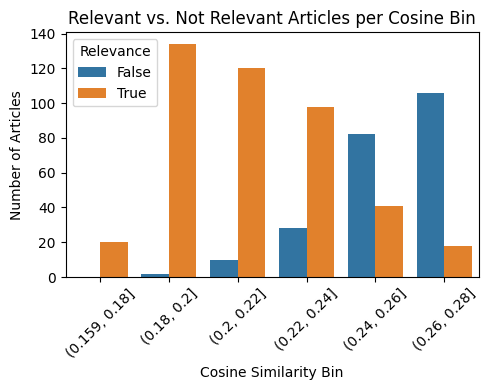

In [14]:
# Plotting
plt.figure(figsize=(5,4))
sns.barplot(
    data=bin_counts,
    x='query_32_cosine_bin',
    y='count',
    hue='woman_murdered'
)
plt.title('Relevant vs. Not Relevant Articles per Cosine Bin')
plt.xlabel('Cosine Similarity Bin')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.legend(title='Relevance')
plt.tight_layout()
plt.show()

In [39]:
# Keyword Analysis: 
# For each keyword, get a count of how many relevant and irrelevant articles are associated with it

# Ensure the keyword column is lowercase for matching
df_key['keyword'] = df_key['keyword'].str.lower()
df_tag['found_keywords'] = df_tag['found_keywords'].str.lower()
df_tag['not_found_keywords'] = df_tag['not_found_keywords'].str.lower()

# Make sure keywords are strings
df_tag['found_keywords'] = df_tag['found_keywords'].astype(str)

# Filter rows where 'has_keyword_data' equals True (boolean)
df_tag_key = df_tag[df_tag['has_keyword_data'] == True].copy()

# Split by comma
df_tag_key['found_keywords_list'] = df_tag_key['found_keywords'].str.split(',')

# Remove extra whitespace and convert to lowercase
df_tag_key['found_keywords_list'] = df_tag_key['found_keywords_list'].apply(
    lambda x: [kw.strip().lower() for kw in x] if isinstance(x, list) else []
)

# Explode into multiple rows
df_tag_key = df_tag_key.explode('found_keywords_list')

# Remove empty keywords and NaN values
df_tag_key = df_tag_key[df_tag_key['found_keywords_list'].notna()]
df_tag_key = df_tag_key[df_tag_key['found_keywords_list'] != '']
df_tag_key = df_tag_key[df_tag_key['found_keywords_list'] != 'nan']

print(f"Total rows after processing: {len(df_tag_key)}")

# Create summary: count of relevant and irrelevant articles per keyword
# Assuming you have a column that indicates relevance (adjust column name as needed)
# Common column names might be: 'relevant', 'is_relevant', 'woman_murdered', etc.

keyword_summary = df_tag_key.groupby('found_keywords_list').agg(
    total_articles=('article_id', 'nunique'),
    relevant_count=('woman_murdered', lambda x: (x == True).sum()),
    irrelevant_count=('woman_murdered', lambda x: (x == False).sum())
).reset_index()

keyword_summary.columns = ['keyword', 'total_articles', 'relevant_count', 'irrelevant_count']

# Sort by total articles descending
keyword_summary = keyword_summary.sort_values('total_articles', ascending=False)

print(f"\nKeyword Summary:")
print(keyword_summary.head(70))

Total rows after processing: 4837

Keyword Summary:
             keyword  total_articles  relevant_count  irrelevant_count
37               tat             472             297               169
4                ehe             424             261               158
29              mord             308             197               103
42               tot             281             184                94
26            gewalt             277             164               109
25           getötet             265             184                79
33             opfer             258             152               102
39               tod             258             187                67
50        verdächtig             201             148                53
34           partner             191              95                91
51       verdächtige             182             134                48
30             morde             165              94                67
46            tötung     

Top 10 Keywords - Highest Relevance Rate:
         keyword  total_articles  relevance_rate  relevant_count  \
5        ehefrau              51       78.431373              40   
31      mordfall              23       78.260870              18   
7        ehemann              78       76.923077              60   
45        tötete              93       75.268817              70   
3        bluttat              23       73.913043              17   
44     totschlag              99       73.737374              73   
50    verdächtig             201       73.631841             148   
51   verdächtige             182       73.626374             134   
39           tod             258       72.480620             187   
52  verdächtigen              93       70.967742              66   

    irrelevant_count  
5                 11  
31                 5  
7                 18  
45                23  
3                  4  
44                25  
50                53  
51                48  
39

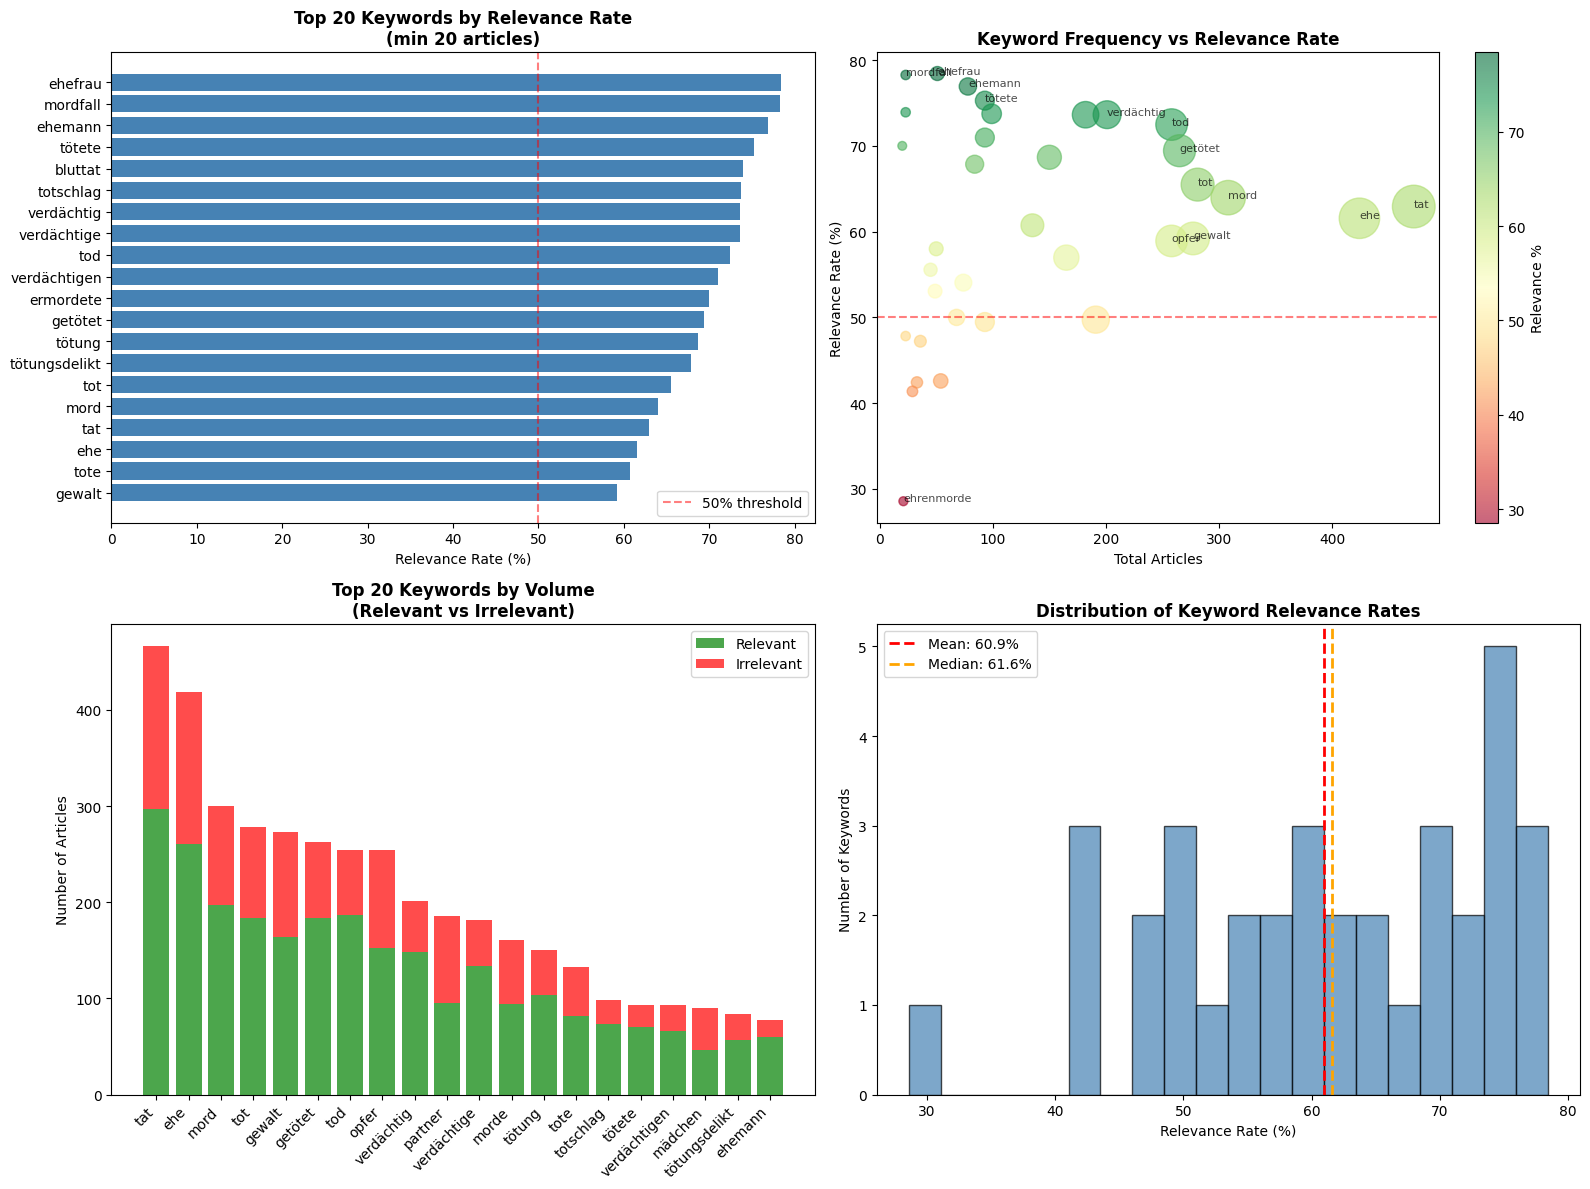


STATISTICAL SUMMARY (Keywords with 20+ articles)
Mean Relevance Rate: 60.94%
Median Relevance Rate: 61.56%
Std Dev: 12.45%

Keywords above 70% relevance (strong predictors): 10
Keywords below 50% relevance (weak/negative predictors): 8


In [40]:
# Calculate relevance metrics for each keyword
keyword_summary['relevance_rate'] = (
    keyword_summary['relevant_count'] / keyword_summary['total_articles'] * 100
)

# Calculate irrelevance rate
keyword_summary['irrelevance_rate'] = (
    keyword_summary['irrelevant_count'] / keyword_summary['total_articles'] * 100
)

# Filter keywords with at least 20 articles for more reliable statistics
keyword_filtered = keyword_summary[keyword_summary['total_articles'] >= 20].copy()

# Sort by relevance rate
keyword_filtered = keyword_filtered.sort_values('relevance_rate', ascending=False)

print("Top 10 Keywords - Highest Relevance Rate:")
print(keyword_filtered[['keyword', 'total_articles', 'relevance_rate', 'relevant_count', 'irrelevant_count']].head(10))
print("\n" + "="*80 + "\n")

print("Top 10 Keywords - Lowest Relevance Rate (Predictors of Irrelevance):")
print(keyword_filtered[['keyword', 'total_articles', 'relevance_rate', 'relevant_count', 'irrelevant_count']].tail(10))

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 20 keywords by relevance rate (min 20 articles)
ax1 = axes[0, 0]
top_relevant = keyword_filtered.head(20)
ax1.barh(range(len(top_relevant)), top_relevant['relevance_rate'], color='steelblue')
ax1.set_yticks(range(len(top_relevant)))
ax1.set_yticklabels(top_relevant['keyword'])
ax1.set_xlabel('Relevance Rate (%)')
ax1.set_title('Top 20 Keywords by Relevance Rate\n(min 20 articles)', fontsize=12, fontweight='bold')
ax1.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
ax1.legend()
ax1.invert_yaxis()

# 2. Scatter plot: Total articles vs Relevance rate
ax2 = axes[0, 1]
scatter = ax2.scatter(keyword_filtered['total_articles'], 
                     keyword_filtered['relevance_rate'],
                     s=keyword_filtered['total_articles']*2,
                     alpha=0.6,
                     c=keyword_filtered['relevance_rate'],
                     cmap='RdYlGn')
ax2.set_xlabel('Total Articles')
ax2.set_ylabel('Relevance Rate (%)')
ax2.set_title('Keyword Frequency vs Relevance Rate', fontsize=12, fontweight='bold')
ax2.axhline(y=50, color='red', linestyle='--', alpha=0.5)
plt.colorbar(scatter, ax=ax2, label='Relevance %')

# Annotate key outliers
for idx, row in keyword_filtered.iterrows():
    if row['total_articles'] > 200 or row['relevance_rate'] > 75 or row['relevance_rate'] < 40:
        ax2.annotate(row['keyword'], 
                    (row['total_articles'], row['relevance_rate']),
                    fontsize=8, alpha=0.7)

# 3. Stacked bar chart - Relevant vs Irrelevant (top 20 by volume)
ax3 = axes[1, 0]
top_volume = keyword_filtered.nlargest(20, 'total_articles')
x_pos = range(len(top_volume))
ax3.bar(x_pos, top_volume['relevant_count'], label='Relevant', color='green', alpha=0.7)
ax3.bar(x_pos, top_volume['irrelevant_count'], 
       bottom=top_volume['relevant_count'], label='Irrelevant', color='red', alpha=0.7)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(top_volume['keyword'], rotation=45, ha='right')
ax3.set_ylabel('Number of Articles')
ax3.set_title('Top 20 Keywords by Volume\n(Relevant vs Irrelevant)', fontsize=12, fontweight='bold')
ax3.legend()

# 4. Distribution of relevance rates
ax4 = axes[1, 1]
ax4.hist(keyword_filtered['relevance_rate'], bins=20, color='steelblue', alpha=0.7, edgecolor='black')
ax4.axvline(x=keyword_filtered['relevance_rate'].mean(), 
           color='red', linestyle='--', linewidth=2, label=f'Mean: {keyword_filtered["relevance_rate"].mean():.1f}%')
ax4.axvline(x=keyword_filtered['relevance_rate'].median(), 
           color='orange', linestyle='--', linewidth=2, label=f'Median: {keyword_filtered["relevance_rate"].median():.1f}%')
ax4.set_xlabel('Relevance Rate (%)')
ax4.set_ylabel('Number of Keywords')
ax4.set_title('Distribution of Keyword Relevance Rates', fontsize=12, fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.show()

# Statistical summary
print("\n" + "="*80)
print("STATISTICAL SUMMARY (Keywords with 20+ articles)")
print("="*80)
print(f"Mean Relevance Rate: {keyword_filtered['relevance_rate'].mean():.2f}%")
print(f"Median Relevance Rate: {keyword_filtered['relevance_rate'].median():.2f}%")
print(f"Std Dev: {keyword_filtered['relevance_rate'].std():.2f}%")
print(f"\nKeywords above 70% relevance (strong predictors): {(keyword_filtered['relevance_rate'] > 70).sum()}")
print(f"Keywords below 50% relevance (weak/negative predictors): {(keyword_filtered['relevance_rate'] < 50).sum()}")